<a href="https://colab.research.google.com/github/ucalyptus/BS-Nets-Implementation-Pytorch/blob/dual-attention/Indian_Pines_BSDA_RecNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import regularizers
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, ReLU, PReLU, MaxPool3D, Conv3DTranspose
from keras.layers import Dropout, Input, GlobalAveragePooling2D, multiply, add, Activation, Permute, merge
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
import tensorflow as tf
from keras.layers import Layer

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

# from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
# import spectral

# init_notebook_mode(connected=True)
%matplotlib inline
# %tensorflow_version 1.x

Using TensorFlow backend.


In [0]:
!pip install -U spectral
if not (os.path.isfile('/content/Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('/content/Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

     |████████████████████████████████| 153kB 3.3MB/s 
  Created wheel for spectral: filename=spectral-0.20-cp36-none-any.whl size=183918 sha256=73067a0adbcad9632bb958fe845e06671a2d886521c7f51adf2e63a5d49d360b
  Stored in directory: /root/.cache/pip/wheels/ad/cf/f3/3cab28f6aed46f15c8db09c6ad678483610426261025e61ff8
Successfully built spectral
--2020-01-26 20:20:33--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   721KB/s    in 9.0s    

2020-01-26 20:20:42 (648 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-01-26 20:20:46--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158

In [0]:
def loadData():
    data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    
    return data, labels

In [0]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [0]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [0]:
X, y = loadData()

In [0]:
X.shape

(145, 145, 200)

In [0]:
X, y = createImageCubes(X, y, 11)

X.shape, y.shape

((10249, 11, 11, 200), (10249,))

# Model and Training

In [0]:
# X = X.reshape(-1, 200, 5, 5)
# X.shape

In [0]:
def BAM():
    model = Sequential()
    model.add(Conv2D(filters=64,
                     input_shape=(11, 11, 200),
                     kernel_size=(3,3),
                     strides=1,
                     padding='valid', name="Conv1"))
    model.add(ReLU(name="ReLU1"))
    model.add(GlobalAveragePooling2D(data_format="channels_first"))
    
    model.add(Dense(128))
    model.add(ReLU(name="ReLU2"))
    model.add(Dense(200, activation="sigmoid"))
  
    return model

In [0]:
# class PAM(Layer):
#     def __init__(self,
#                  gamma_initializer=tf.zeros_initializer(),
#                  gamma_regularizer=None,
#                  gamma_constraint=None,
#                  **kwargs):
#         super(PAM, self).__init__(**kwargs)
#         self.gamma_initializer = gamma_initializer
#         self.gamma_regularizer = gamma_regularizer
#         self.gamma_constraint = gamma_constraint

#     def build(self, input_shape):
#         self.gamma = self.add_weight(shape=(1, ),
#                                      initializer=self.gamma_initializer,
#                                      name='gamma',
#                                      regularizer=self.gamma_regularizer,
#                                      constraint=self.gamma_constraint)

#         self.built = True

#     def compute_output_shape(self, input_shape):
#         return input_shape

#     def call(self, input):
#         input_shape = input.get_shape().as_list()
#         _, h, w, filters = input_shape

#         b = Conv2D(filters // 8, 1, use_bias=False, kernel_initializer='he_normal')(input)
#         c = Conv2D(filters // 8, 1, use_bias=False, kernel_initializer='he_normal')(input)
#         d = Conv2D(filters, 1, use_bias=False, kernel_initializer='he_normal')(input)

#         vec_b = K.reshape(b, (-1, h * w, filters // 8))
#         vec_cT = tf.transpose(K.reshape(c, (-1, h * w, filters // 8)), (0, 2, 1))
#         bcT = K.batch_dot(vec_b, vec_cT)
#         softmax_bcT = Activation('softmax')(bcT)
#         vec_d = K.reshape(d, (-1, h * w, filters))
#         bcTd = K.batch_dot(softmax_bcT, vec_d)
#         bcTd = K.reshape(bcTd, (-1, h, w, filters))

#         out = self.gamma*bcTd + input
#         return out


# class CAM(Layer):
#     def __init__(self,
#                  gamma_initializer=tf.zeros_initializer(),
#                  gamma_regularizer=None,
#                  gamma_constraint=None,
#                  **kwargs):
#         super(CAM, self).__init__(**kwargs)
#         self.gamma_initializer = gamma_initializer
#         self.gamma_regularizer = gamma_regularizer
#         self.gamma_constraint = gamma_constraint

#     def build(self, input_shape):
#         self.gamma = self.add_weight(shape=(1, ),
#                                      initializer=self.gamma_initializer,
#                                      name='gamma',
#                                      regularizer=self.gamma_regularizer,
#                                      constraint=self.gamma_constraint)

#         self.built = True

#     def compute_output_shape(self, input_shape):
#         return input_shape

#     def call(self, input):
#         input_shape = input.get_shape().as_list()
#         _, h, w, filters = input_shape

#         vec_a = K.reshape(input, (-1, h * w, filters))
#         vec_aT = tf.transpose(vec_a, (0, 2, 1))
#         aTa = K.batch_dot(vec_aT, vec_a)
#         softmax_aTa = Activation('softmax')(aTa)
#         aaTa = K.batch_dot(vec_a, softmax_aTa)
#         aaTa = K.reshape(aaTa, (-1, h, w, filters))

#         out = self.gamma*aaTa + input
#         return out
      
# def DA():
#     input_layer = Input((11, 11, 200))
#     pam = PAM()(input_layer)
#     cam = CAM()(input_layer)
    
#     feature_sum = add([pam, cam])
    
#     return Model(inputs=input_layer, outputs=feature_sum)

In [0]:
def DCAE(weight_decay=0.0005):
    model = Sequential()
    model.add(Conv3D(filters=24,
                     input_shape=(200, 11, 11, 1),
                     kernel_size=(24, 3, 3),
                     strides=(1, 1, 1),
                     kernel_regularizer=regularizers.l2(l=weight_decay),
                     padding='valid', name="Conv1"))
    model.add(BatchNormalization(name="BN1"))
    model.add(PReLU(name="PReLU1"))

    model.add(Conv3D(filters=48,
                     kernel_size=(24, 3, 3),
                     strides=(1, 1, 1),
                     kernel_regularizer=regularizers.l2(l=weight_decay),
                     padding='valid', name="Conv2"))
    model.add(BatchNormalization(name="BN2"))
    model.add(PReLU(name="PReLU2"))

    model.add(MaxPool3D(pool_size=(18, 1, 1),
                        strides=(18, 1, 1), name="Pool1"))

    model.add(Conv3DTranspose(filters=24,
                              kernel_size=(9, 3, 3),
                              kernel_regularizer=regularizers.l2(
                                  l=weight_decay),
                              strides=(22, 1, 1), name="Deconv1", padding='valid'))
    model.add(BatchNormalization(name="BN3"))
    model.add(PReLU(name="PReLU3"))
    model.add(Conv3DTranspose(filters=1,
                              kernel_size=(25, 3, 3),
                              kernel_regularizer=regularizers.l2(
                                  l=weight_decay),
                              strides=(1, 1, 1), name="Deconv2", padding='valid'))
    model.add(BatchNormalization(name="BN4"))
    
    return model

In [0]:
def Ensemble():
    input_layer = Input((11, 11, 200))
    band_activations = BAM()(input_layer)
    # band_activations = Reshape((200, 1, 1))(band_activations)
    
    bam_output = multiply([band_activations, input_layer])
    
    bam_output = Reshape((200, 11, 11, 1))(bam_output)
    # da_output = DA()(input_layer)
    # da_output = Permute((3,1,2), input_shape=(11,11,200))(da_output)
    # da_output = Reshape((200, 11, 11, 1))(da_output)
    output = DCAE()(bam_output)
    
    
    return Model(inputs=input_layer, outputs=output)
    

In [0]:
# model = DCAE(weight_decay=0.0005)
model = Ensemble()
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 11, 200)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 200)          142344      input_1[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 11, 11, 200)  0           sequential_1[1][0]               
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 200, 11, 11,  0           multiply_1[0][0]       

In [0]:
def psnr(x_true, x_pred):
    n_samples = x_true.shape[0]
    n_bands = x_true.shape[1]
    PSNR = np.zeros(n_bands)
    MSE = np.zeros(n_bands)
    mask = np.ones(n_bands)
    for k in range(n_bands):
        x_true_k = x_true[:, k].reshape([-1])
        x_pred_k = x_pred[:, k].reshape([-1])
        MSE[k] = 1.0 / n_samples * mean_squared_error(x_true_k, x_pred_k, )
        MAX_k = np.max(x_true_k)
        if MAX_k != 0:
            PSNR[k] = 10 * math.log10(math.pow(MAX_k, 2) / MSE[k])
        else:
            mask[k] = 0

    psnr = PSNR.sum()/mask.sum()
    mse = MSE.mean()
    print('psnr', psnr)
    print('mse', mse)
    
    return psnr, mse

In [0]:
import scipy
from scipy.special import kl_div
def Dskl(Bi,Bj):
  
  
  pk = np.histogramdd(np.ravel(Bi), bins = 256)[0]/Bi.size 
  #pk = list(filter(lambda p: p > 0, pk))
  pk = np.array(pk)

  qk = np.histogramdd(np.ravel(Bj), bins = 256)[0]/Bj.size
  #qk = list(filter(lambda p: p > 0, qk)
  qk = np.array(qk)
  
  
  S = kl_div(pk,qk) + kl_div(qk,pk)
  
  #S = np.sum(pk * np.log2(pk / qk), axis=0) + np.sum(qk * np.log2(qk / pk), axis=0)
  
  return S

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
ENTROPY = np.zeros(200)
import skimage.measure
def topkbands(x_predict, topk):
  for i in range(0,len(ENTROPY)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(x_predict[:,i,:,:])
  
  print('Top k bands with Entropy ->',ENTROPY.argsort()[-topk:][::-1])

In [0]:
def MSD(x_predict, topk):
  top = ENTROPY.argsort()[-topk:][::-1]
  perbatch = list(0 for i in range(0,160))
  for batch_idx in range(0,len(perbatch)):
    for i in range(0,len(top)):
      for j in range(0,i):
        perbatch[batch_idx]+=Dskl(x_predict[:,top[i],:,:],x_predict[:,top[j],:,:])
  perbatch = np.array(perbatch)
  perbatch[perbatch>=1E03]=0
  print('Mean of MSD with Top k bands is \n',np.mean(perbatch)*100)

In [0]:
def plott(ENTROPY):
  fig = plt.figure(figsize=(40,4))
  ax1 = fig.add_subplot(121)
  ax1.plot(ENTROPY)



In [0]:
ENTROPY = np.zeros(200)
import skimage.measure
def output_entropy(x_predict):
  for i in range(0,len(ENTROPY)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(x_predict[:,i,:,:])
  plott(ENTROPY)
  

In [0]:
from keras.callbacks import Callback
from sklearn.metrics import mean_squared_error
import math

class MyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
      pass
        #x_predict = model.predict(X)
       # x_true = np.asarray(X)
       # x_pred_centre = x_predict[:, :, 2, 2]
       # x_true_centre = x_true[:, :, 2, 2]
       # psnr(x_true_centre, x_pred_centre)
       # topkbands(x_predict, 15)
    def on_train_end(self,logs=None):
      x_predict = model.predict(X)
      output_entropy(x_predict)
      #MSD(x_predict, 30)

Epoch 1/50
10249/10249 [==============================] - 89s 9ms/step - loss: 8761893.5203
Epoch 2/50
10249/10249 [==============================] - 87s 8ms/step - loss: 8727215.8598
Epoch 3/50
10249/10249 [==============================] - 86s 8ms/step - loss: 8694071.4020
Epoch 4/50
10249/10249 [==============================] - 86s 8ms/step - loss: 8661113.8521
Epoch 5/50
10249/10249 [==============================] - 86s 8ms/step - loss: 8628325.5424
Epoch 6/50
10249/10249 [==============================] - 86s 8ms/step - loss: 8595654.9985
Epoch 7/50
10249/10249 [==============================] - 86s 8ms/step - loss: 8563032.0400
Epoch 8/50
10249/10249 [==============================] - 86s 8ms/step - loss: 8530504.6073
Epoch 9/50
10249/10249 [==============================] - 86s 8ms/step - loss: 8498080.3015
Epoch 10/50
10249/10249 [==============================] - 86s 8ms/step - loss: 8465804.2534
Epoch 11/50
10249/10249 [==============================] - 86s 8ms/step - loss:

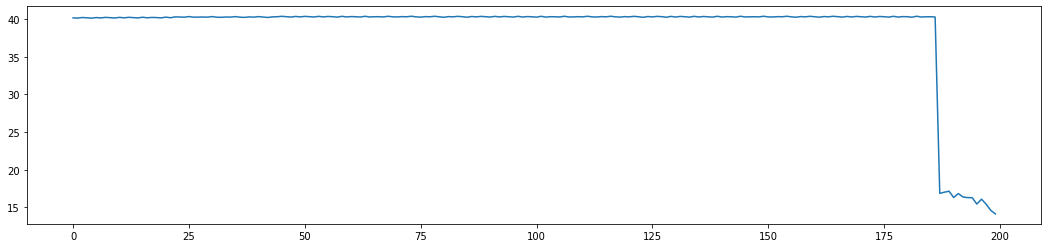

In [0]:
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=0.1))

n_epoch = 50

model.fit(X, X.reshape(-1, 200, 11, 11, 1), epochs=n_epoch, shuffle=True, verbose=1, batch_size=256, callbacks=[MyLogger()])

In [0]:
sel_bands = sorted([ 68, 182,  73, 149,  63, 111, 106, 116, 154, 144,  78,  58, 159, 101, 139])

In [0]:
X, y = loadData()

In [0]:
X_ = X[:, :, sel_bands[0]]
for i in sel_bands[1:]:
  X_ = np.dstack((X_, X[:, :, i]))

In [0]:
X_.shape

In [0]:
img_rows, img_cols = 11, 11
nb_classes = 16
img_channels = 15

In [0]:
import ssrn_SS_IN 

model_res4 = ssrn_SS_IN.ResnetBuilder.build_resnet_8((1, img_rows, img_cols, img_channels), nb_classes)

In [0]:
# ## input layer
# input_layer = Input((5, 5, 30, 1))

# ## convolutional layers
# conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu', padding='same')(input_layer)
# conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu', padding='same')(conv_layer1)
# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(conv_layer2)
# print(conv_layer3._keras_shape)
# conv3d_shape = conv_layer3._keras_shape
# conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
# conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

# flatten_layer = Flatten()(conv_layer4)

# ## fully connected layers
# dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
# dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.4)(dense_layer2)
# output_layer = Dense(units=16, activation='softmax')(dense_layer2)

# model_res4 = Model(inputs=input_layer, outputs=output_layer)

In [0]:
adam = Adam(lr=0.0001, decay=1e-06)
model_res4.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
X, y = createImageCubes(X_, y, 11)

In [0]:
X.shape, y.shape

In [0]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [0]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, 0.5)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

In [0]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.5)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

In [0]:
Xtrain = Xtrain.reshape(-1, 11, 11, 15, 1)
Xtrain.shape

In [0]:
Xvalid = Xvalid.reshape(-1, 11, 11, 15, 1)
Xvalid.shape

In [0]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

In [0]:
yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [0]:
model_res4.summary()

In [0]:
history = model_res4.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=500, validation_data=(Xvalid, yvalid))

In [0]:
Xtest = Xtest.reshape(-1, 11, 11, 15, 1)
Xtest.shape

In [0]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

Y_pred_test = model_res4.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [0]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [0]:
def reports (X_test,y_test):
    #start = time.time()
    Y_pred = model_res4.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)

    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                    ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model_res4.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [0]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))